<a href="https://colab.research.google.com/github/ziatdinovmax/ML-ElectronMicroscopy-2023/blob/main/Lecture%2024/VAE_and_cVAE_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders from Scratch

*Notebook prepared by Maxim Ziatdinov (2023)*

This notebook provides a hands-on guide to implementing Variational Autoencoders (VAEs) in PyTorch. VAEs are a powerful generative model known for their ability to learn rich latent representations of data.

Briefly, VAEs operate by encoding input data into a latent space and then decoding it back to the original space. The beauty of this model lies in its probabilistic nature. Instead of encoding to a fixed point in the latent space, a VAE encodes to a distribution. This introduces a regularizing effect, ensuring that similar inputs have similar encodings, and provides the model with its generative capabilities.

The training process involves two primary components: a reconstruction loss ensuring that decoded outputs closely match the original inputs, and a KL divergence term that regularizes the learned distributions to be close to a prior (usually a standard normal distribution). Balancing these components allows the VAE to learn meaningful latent structures while maintaining its generative prowess.

In this notebook, we'll dive deep into the implementation details, breaking down each component and function. We'll construct our VAE from scratch, ensuring a clear understanding of every aspect of the model, from the architecture design to the optimization strategy.

Make neccessary imports:

In [ ]:
from typing import Tuple, Optional, Type

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets

import math

import matplotlib.pyplot as plt

Next, we download training data. For the illustration purposes, we will be using MNIST dataset.

In [ ]:
!wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxf MNIST.tar.gz
mnist = datasets.MNIST(
    root='.', train=True, download=False, transform=None)
data = mnist.data
data = data.flatten(1)
data = data / data.max()

In the VAE model, we have two primary components: the Encoder and the Decoder.

**Encoder:** This component is responsible for compressing the input data into a latent representation. Specifically, the Encoder takes the input data and passes it through multiple linear and activation layers.
The final layers of the Encoder produce two outputs: the mean (```mean```) and the log standard deviation (```logstd```). These define the parameters of the Gaussian distribution in the latent space, from which we'll sample during the decoding phase.
Decoder: This component works on reconstructing the original data from the latent representation.

**Decoder:** It starts by taking the latent variable (derived from the encoded output) and runs it through its hidden layers.
The final output is the reconstructed data, which, in this case, is passed through a sigmoid activation, ensuring its values lie between 0 and 1. This is especially useful when dealing with image data or any other type of data that requires a bounded output.

Below is the PyTorch implementation of both components:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Encoder, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*layers)

        # Mean and log variance layers
        self.fc_mean = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logstd = nn.Linear(hidden_dims[-1], latent_dim)

    def forward(self, x):
        h = self.hidden_layers(x)
        mean = self.fc_mean(h)
        logstd = self.fc_logstd(h)
        return mean, logstd

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()

        layers = []
        layers.append(nn.Linear(latent_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*layers)

        # Output layer
        self.fc_out = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, z):
        h = self.hidden_layers(z)
        reconstruction = torch.sigmoid(self.fc_out(h))
        return reconstruction

Now let's construct basic VAE class that stitches together the core functionalities of a Variational Autoencoder.

**Initialization:**

The VAE takes in an encoder and decoder as its primary components.
We also determine if we can leverage GPU acceleration by checking the availability of CUDA and adjust the device accordingly.

**KL Divergence:**

The method ```compute_kld``` calculates the KL divergence, which measures how one probability distribution diverges from a second expected probability distribution. In our VAE, it measures the difference between our learned distribution in the latent space and a prior distribution (often a standard normal distribution).

**Likelihood:**

The method ```compute_likelihood``` computes the likelihood of our data under the model's reconstructions. This is effectively the negative reconstruction loss and gives us an indication of how well our model's reconstructions explain the input data.

**Reparametrization Trick:**

VAEs utilize a technique known as the "reparametrization trick" to backpropagate through the stochastic nodes. The ```_reparameterize``` method implements this by adding a random noise scaled by the standard deviation to the mean of our latent distribution.

**Probability Distributions:**

The ```_log_normal``` method calculates the log-pdf of a normal distribution for a given input, mean, and log variance.
Similarly, the ```_log_unit_normal``` method computes the log-pdf of a unit normal distribution for a given input. They are used in the ```compute_kld``` method to calculate the KL divergence term.

**Forward Pass:**

The forward method orchestrates the entire process: encoding the input data, sampling from the latent space using the reparametrization trick, computing the KL divergence, decoding to get the reconstructions, and finally computing the likelihood.



In [ ]:
class VAE(nn.Module):

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()

        device = "cuda" if torch.cuda.is_available() else 'cpu'

        self.encoder = encoder
        self.decoder = decoder

        self.to(device)
        self.device = device


    def compute_kld(self,
                     z: torch.Tensor,
                     q_param: Tuple[torch.Tensor],
                     p_param: Optional[Tuple[torch.Tensor]] = None
                     ) -> torch.Tensor:
        """
        Computes KL divergence term between two normal distributions
        or (if p_param = None) between normal and standard normal distributions
        """
        qz = self._log_normal(z, *q_param)
        if p_param is None:
            pz = self._log_unit_normal(z)
        else:
            pz = self._log_normal(z, *p_param)
        return qz - pz


    def compute_likelihood(self,
                           x: torch.Tensor,
                           x_reconstr: torch.Tensor
                           ) -> torch.Tensor:
        """
        Computes how well the model's reconstructions explain the data
        (which is effectively negative negative reconstruction loss)
        """
        reconstr_loss = F.binary_cross_entropy(
            x_reconstr.flatten(1), x.flatten(1), reduction='none').sum(-1)

        return -reconstr_loss

    @classmethod
    def _reparameterize(cls,
                        z_mu: torch.Tensor,
                        z_logsig: torch.Tensor
                        ) -> torch.Tensor:
        """Reparametrization trick"""
        batch_dim = z_mu.size(0)
        z_dim = z_mu.size(1)
        z_sig = torch.exp(z_logsig)
        eps = z_mu.new(batch_dim, z_dim).normal_()
        return z_mu + z_sig * eps

    @classmethod
    def _log_normal(cls,
                   x: torch.Tensor,
                   mu: torch.Tensor,
                   log_sig: torch.Tensor
                   ) -> torch.Tensor:
        """
        Computes log-pdf of a normal distribution
        """
        log_pdf = (-0.5 * math.log(2 * math.pi) - log_sig -
                   (x - mu)**2 / (2 * torch.exp(log_sig)**2))
        return torch.sum(log_pdf, dim=-1)

    @classmethod
    def _log_unit_normal(cls, x: torch.Tensor) -> torch.Tensor:
        """
        Computes log-pdf of a unit normal distribution
        """
        log_pdf = -0.5 * (math.log(2 * math.pi) + x ** 2)
        return torch.sum(log_pdf, dim=-1)


    def forward(self, x: torch.Tensor):
        """Forward pass"""

        self.kl_divergence = 0
        self.likelihood = 0
        # Encode data
        z_mu, z_logsig = self.encoder(x)
        # Obtain latent vector throught the 'reparametrization trick'
        z_vec = self._reparameterize(z_mu, z_logsig)
        # Compute KLD
        self.kl_divergence += self.compute_kld(z_vec, (z_mu, z_logsig))
        # Pass latent vector to the decoder
        x_reconstr = self.decoder(z_vec)
        # Compute likelihood (negative reconstruction loss)
        self.likelihood += self.compute_likelihood(x, x_reconstr)

        return x_reconstr

With this setup, our VAE is ready to be trained using a combination of reconstruction loss and KL divergence, optimizing its ability to generate new samples while maintaining meaningful latent representations of the input data.

Let's proceed and initialize our VAE with simple encoder and decoder neural nets and set up a standard PyTorch optimizer to adjust the parameters of the VAE during training:

In [ ]:
encoder = Encoder(784, [512, 256, 128], 2)
decoder = Decoder(2, [128, 256, 512], 784)

vae_model = VAE(encoder, decoder)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-4)

Next we initialize the data loading mechanism for the model training using built-in PyTorch utilities:

In [ ]:
def init_dataloader(*args: torch.Tensor,
                    batch_size: int = 100,
                    shuffle: bool = True,
                    ) -> Type[torch.utils.data.DataLoader]:
    """
    Returns initialized PyTorch dataloader
    """
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    data_loader = torch.utils.data.DataLoader(
            dataset=tensor_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


train_loader = init_dataloader(data)

Finally we are ready to train our model. The loss function for a VAE is given by:

\begin{equation}
L(\theta, \phi; x) = -\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] + \beta D_{KL}(q_\phi(z|x) || p(z))
\end{equation}

Where:
- $x$ is the observed data point,
- $z$ is the latent variable or encoding of the data point,
- $\theta$ are the parameters of the decoder network,
- $\phi$ are the parameters of the encoder network,
- $p_\theta(x|z)$ is the likelihood of the data given the latent variable, modeled by the decoder,
- $q_\phi(z|x)$ is the approximate posterior distribution of the latent variable given the data, modeled by the encoder,
- $\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$ is the expected log likelihood of the data given its reconstruction (reconstruction loss),
- $D_{KL}(q_\phi(z|x) || p(z))$ is the KL Divergence between the encoder's distribution and a prior distribution,
- $p(z)$ is the prior distribution for the latent variable, often a standard normal distribution.

Note the hyperparameter β that helps controlling the trade-off between the two training objective:

**β = 1:** This represents the standard VAE, where both objectives are equally weighed.

**β > 1:** The KL-divergence term becomes more dominant, which might lead to a more regularized latent space. However, this could also cause the model to prioritize the latent distribution over accurate reconstructions, which may degrade the quality of the reconstructed outputs.

**β < 1:**T his places more emphasis on the reconstruction loss. While this could result in better reconstructions of the inputs, the latent space might not be as well-structured or regular.

The β value can be tuned based on the specific use-case and the importance of each objective.

With this information, let's define a single training step:

In [ ]:
def train_step(x: torch.Tensor, beta: int = 1) -> torch.Tensor:
    """Conducts a single training step for a VAE model"""
    # Set the model to training mode
    vae_model.train()
    # Perform a forward pass with input tensor x
    _ = vae_model(x.to(vae_model.device))
    # Compute the loss: negative likelihood + beta * KL divergence. Then, take the mean over the batch.
    loss = (-vae_model.likelihood + beta * vae_model.kl_divergence).mean()
    # Perform backpropagation to compute gradient of loss w.r.t. model parameters.
    loss.backward()
    # Update the model parameters using the computed gradients.
    optimizer.step()
    # Reset gradients to zero for the next iteration.
    optimizer.zero_grad()
    # Return the loss value as a Python scalar.
    return loss.item()

Train the VAE model:

In [ ]:
epochs = 100

train_loss = []
for e in range(epochs):
    train_loss_i = 0
    for (x,) in train_loader:
        loss_i= train_step(x)
        train_loss_i += loss_i

    train_loss.append(train_loss_i / len(train_loader))
    print("Epoch {},  Train loss {}".format(e+1, train_loss[-1]))

Epoch 1,  Train loss 229.8956323750814
Epoch 2,  Train loss 194.42987770080566
Epoch 3,  Train loss 188.57814463297527
Epoch 4,  Train loss 179.6371627553304
Epoch 5,  Train loss 169.40054293314617
Epoch 6,  Train loss 165.45718368530274
Epoch 7,  Train loss 162.90721786499023
Epoch 8,  Train loss 160.5627067820231
Epoch 9,  Train loss 158.3137289174398
Epoch 10,  Train loss 156.64729347229004
Epoch 11,  Train loss 155.34848205566405
Epoch 12,  Train loss 154.19540674845376
Epoch 13,  Train loss 153.22688199361164
Epoch 14,  Train loss 152.354743754069
Epoch 15,  Train loss 151.45793413798015
Epoch 16,  Train loss 150.6256556193034
Epoch 17,  Train loss 149.82213770548503
Epoch 18,  Train loss 149.08880477905274
Epoch 19,  Train loss 148.33712145487468
Epoch 20,  Train loss 147.62025868733724
Epoch 21,  Train loss 146.95416208902995
Epoch 22,  Train loss 146.43813044230143
Epoch 23,  Train loss 145.8872991434733
Epoch 24,  Train loss 145.42596738179526
Epoch 25,  Train loss 145.0403052

Text(0, 0.5, 'Loss')

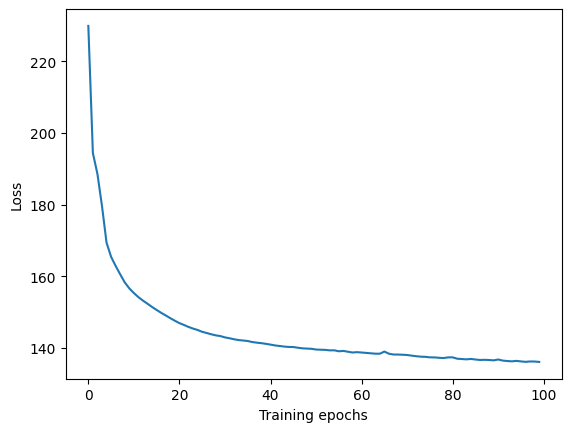

In [ ]:
plt.plot(train_loss)
plt.xlabel("Training epochs")
plt.ylabel("Loss")

Having trained our VAE model, our next task is to inspect its performance, especially how it encodes data into the latent space:

```vae_model.eval()```: We switch the VAE model to evaluation mode. This ensures layers like dropout, batch normalization, etc., behave correctly during inference (although we don't have them in this specific implementation).

```test_loader```: A new data loader is initialized for our test dataset. Notably, we set shuffle to False. This ensures the data order remains consistent, allowing us to match encoded data in the latent space to their ground truth labels.

```with torch.no_grad()```: This context manager tells PyTorch that we don't need to compute gradients for the upcoming operations, optimizing memory usage and processing speed during this inference phase.

The ```for (x,) in test_loader``` iterates over batches of test data. We do this to avoid memory overflow. For each batch x, it passes the data through the VAE's encoder to obtain the mean of the latent distribution (i.e., ```vae_model.encoder(x.to(vae_model.device))[0]```). These latent representations are concatenated across batches to form the tensor ```z```, which holds the encoded representations for the entire test dataset.







In [ ]:
vae_model.eval()
test_loader = init_dataloader(data, shuffle=False) # set shuffle to False so that we can compare to the ground truth labels
with torch.no_grad():
    z = torch.cat([vae_model.encoder(x.to(vae_model.device))[0].cpu() for (x,) in test_loader])

Plot encoded latent represenation:

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Text(0, 0.5, '$z_2$')

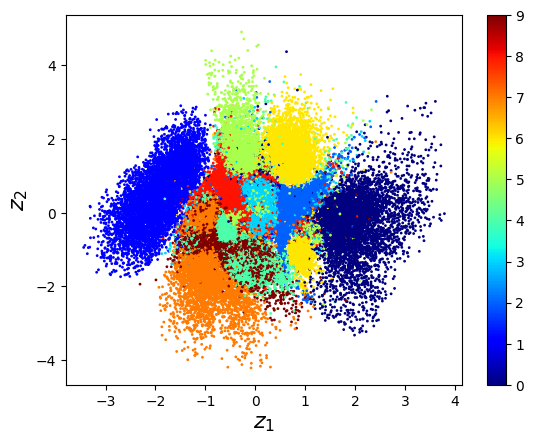

In [ ]:
plt.scatter(z[:, 1], z[:, 0], s=1, c=mnist.train_labels, cmap='jet')
plt.colorbar()
plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16)

To understand how our VAE model captures the intrinsic structure of the data, we can explore its ability to generate new samples as we traverse its latent space. A common way to do this is by generating a grid of points in the latent space and decoding them.

The ```generate_latent_grid``` utility function is designed to generate a grid of coordinates in the latent space. Here, ```dist.Normal(0, 1).icdf(...)``` generates a set of coordinates based on the inverse cumulative distribution function (ICDF) of a standard normal distribution. It produces a series of points spaced according to the distribution's quantiles, ensuring a smooth sampling across the latent space.

With our grid ```z_grid``` in hand, we pass these through the VAE's decoder to obtain generated samples corresponding to each point in the latent space grid. This gives us a latent manifold — a collection of generated samples that represent how our VAE decodes different regions of its latent space.

In [ ]:
def generate_latent_grid(d=10):
    """
    Generates a grid of latent space coordinates
    """
    dist = torch.distributions
    if isinstance(d, int):
        d = [d, d]
    grid_x = dist.Normal(0, 1).icdf(torch.linspace(0.95, 0.05, d[0]))
    grid_y = dist.Normal(0, 1).icdf(torch.linspace(0.05, 0.95, d[1]))
    z = []
    for xi in grid_x:
        for yi in grid_y:
            z.append(torch.tensor([xi, yi]).float().unsqueeze(0))
    return torch.cat(z), (grid_x, grid_y)

d = 20
z_grid, (gridx, gridy) = generate_latent_grid(d)

with torch.no_grad():
    manifold = vae_model.decoder(z_grid.to(vae_model.device)).cpu()

# reshapes the decoded samples into images of size 28x28 allowing for straightforward visualization with torchvision
manifold = manifold.reshape(int(d*d), 1, 28, 28)

Visualize results:

([], [])

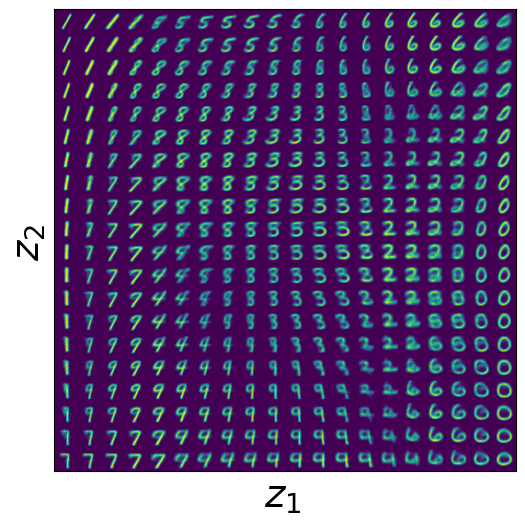

In [ ]:
grid = torchvision.utils.make_grid(manifold, nrow=d, padding=2, pad_value=0)[0]
plt.figure(figsize=(6,6))
plt.imshow(grid, cmap='viridis')
plt.xlabel("$z_1$ ", fontsize=28)
plt.ylabel("$z_2$ ", fontsize=28)
plt.xticks([])
plt.yticks([])

# Conditional Variational Autoencoder

The Conditioned Variational Autoencoder (cVAE) is an extension of the traditional VAE. While a standard VAE learns to encode and decode data unsupervised, a cVAE conditions this process on additional information, typically in the form of labels or attributes. By conditioning on such auxiliary input, the cVAE can generate data samples with specific desired properties or characteristics. This makes cVAEs particularly useful for enhancing the interpretability of latent representations.

The cVAE subclass inherits from the VAE class. The forward method now accepts two inputs: $x$, the data sample, and $c$, the condition. The condition is concatenated with input data and latent vector during the encoding and decoding processes, respectively, enabling the model to generate context-specific representations and reconstructions.

In [ ]:
class cVAE(VAE):
    def __init__(self, encoder, decoder):
        super(cVAE, self).__init__(encoder, decoder)

    def forward(self, x: torch.Tensor, c: torch.Tensor):
        self.kl_divergence = 0
        self.likelihood = 0

        # Concatenate input data x with condition c before passing it to the encoder
        z_mu, z_logsig = self.encoder(torch.cat([x, c], dim=1))

        # Obtain latent vector through the 'reparametrization trick'
        z_vec = self._reparameterize(z_mu, z_logsig)

        # Compute KLD
        self.kl_divergence += self.compute_kld(z_vec, (z_mu, z_logsig))

        # Concatenate latent vector z_vec with condition c before passing it to the decoder
        x_reconstr = self.decoder(torch.cat([z_vec, c], dim=1))

        # Compute likelihood (negative reconstruction loss)
        self.likelihood += self.compute_likelihood(x, x_reconstr)

        return x_reconstr


In [ ]:
# convert integer labels to one-hot representation
def to_onehot(idx, n):
    onehot = torch.zeros(idx.size(0), n)
    return onehot.scatter_(1, idx, 1)

labels = to_onehot(mnist.train_labels.unsqueeze(1), n=10)
labels.shape

torch.Size([60000, 10])

Pass the labels together with data to the train loader:

In [ ]:
train_loader = init_dataloader(data, labels)

Initialize cVAE model. Note that now the Encoder's input dimension is 784 + 10, combining the 784-dimension image with a 10-dimensional condition (one-hot encoded labels). The Decoder starts with an input of 2 + 10 dimensions, representing the latent space combined with the same 10-dimensional condition.

In [ ]:
# Initialize the encoder and decoder
encoder = Encoder(784+10, [512, 256, 128], 2)
decoder = Decoder(2+10, [128, 256, 512], 784)

cvae_model = cVAE(encoder, decoder)
optimizer = torch.optim.Adam(cvae_model.parameters(), lr=1e-4)

In the updated ```train_step``` function, a new input c is introduced, representing the condition on which the generation process is conditioned. This is passed alongside the primary data x to the model.

In [ ]:
def train_step(x: torch.Tensor, c: torch.Tensor, beta: int = 1) -> torch.Tensor:
    """Conducts a single training step for a VAE model"""
    # Set the model to training mode
    cvae_model.train()
    # Perform a forward pass with input tensor x
    _ = cvae_model(x.to(cvae_model.device), c.to(cvae_model.device))
    # Compute the loss: negative likelihood + beta * KL divergence. Then, take the mean over the batch.
    loss = (-cvae_model.likelihood + beta * cvae_model.kl_divergence).mean()
    # Perform backpropagation to compute gradient of loss w.r.t. model parameters.
    loss.backward()
    # Update the model parameters using the computed gradients.
    optimizer.step()
    # Reset gradients to zero for the next iteration.
    optimizer.zero_grad()
    # Return the loss value as a Python scalar.
    return loss.item()

In [ ]:
epochs = 100

train_loss = []
for e in range(epochs):
    train_loss_i = 0
    for (x, c) in train_loader:
        loss_i= train_step(x, c)
        train_loss_i += loss_i

    train_loss.append(train_loss_i / len(train_loader))
    print("Epoch {},  Train loss {}".format(e+1, train_loss[-1]))

Epoch 1,  Train loss 231.90525784810384
Epoch 2,  Train loss 177.83877754211426
Epoch 3,  Train loss 164.2028916422526
Epoch 4,  Train loss 156.37307365417482
Epoch 5,  Train loss 151.96914326985677
Epoch 6,  Train loss 148.4349461619059
Epoch 7,  Train loss 145.56176981608073
Epoch 8,  Train loss 143.31868825276692
Epoch 9,  Train loss 141.56457148234048
Epoch 10,  Train loss 140.11173581441244
Epoch 11,  Train loss 138.86171646118163
Epoch 12,  Train loss 137.8191897837321
Epoch 13,  Train loss 136.91015059153239
Epoch 14,  Train loss 136.1836962636312
Epoch 15,  Train loss 135.56853098551431
Epoch 16,  Train loss 135.0401512781779
Epoch 17,  Train loss 134.55445636749266
Epoch 18,  Train loss 134.1289714304606
Epoch 19,  Train loss 133.74233441670737
Epoch 20,  Train loss 133.38667376200357
Epoch 21,  Train loss 133.07246713002522
Epoch 22,  Train loss 132.79711294809977
Epoch 23,  Train loss 132.5283222961426
Epoch 24,  Train loss 132.2855128733317
Epoch 25,  Train loss 132.0435399

We can now visualize a latent manifold for each class (digit type):

In [ ]:
cls = 2

# The integer class label is converted to a tensor
cls = torch.tensor([cls,]).unsqueeze(1)
# The integer class label tensor is converted to a one-hot encoded tensor
cls = to_onehot(cls, n=10)
# The one-hot encoded class tensor is expanded to match the number of samples in the z_grid.
# This means for every latent space point in z_grid, there's a corresponding class label in the one-hot format.
cls = cls.expand(len(z_grid), *cls.shape[1:])
# The latent vectors (z_grid) and the one-hot encoded class tensors (cls) are concatenated
# along the last dimension, forming a conditioned latent space.
z_grid_c = torch.cat([z_grid, cls], dim=-1).to(cvae_model.device)

# The rest is the same as in the standard VAE
with torch.no_grad():
    manifold = cvae_model.decoder(z_grid_c).cpu()

# reshapes the decoded samples into images of size 28x28 allowing for straightforward visualization with torchvision
manifold = manifold.reshape(int(d*d), 1, 28, 28)

([], [])

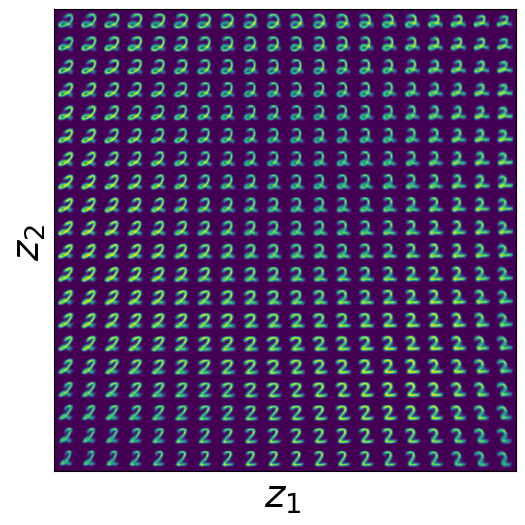

In [ ]:
grid = torchvision.utils.make_grid(manifold, nrow=d, padding=2, pad_value=0)[0]
plt.figure(figsize=(6,6))
plt.imshow(grid, cmap='viridis')
plt.xlabel("$z_1$ ", fontsize=28)
plt.ylabel("$z_2$ ", fontsize=28)
plt.xticks([])
plt.yticks([])